In [2]:
import yfinance as yf
import seaborn as sns
import pandas  as pd
import numpy as np
import pandas_market_calendars as mcal
import pytz

from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process

import scipy.stats as ss
from scipy.integrate import quad
from typing import List, Optional
from scipy.stats import lognorm
from scipy.stats import norm
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

from utils.gbm import GBMAnalyzer
from utils.dataFetcher import OptionsDataFetcher as odf

In [3]:
fetcher = odf("AAPL")
stock_data = fetcher.fetch_stock_data("2015-01-01", "2024-01-01")
opts_data = fetcher.fetch_options_chain()
opts_data_p = fetcher.fetch_options_chain(puts_only = True)
opts_data_c = fetcher.fetch_options_chain(calls_only = True)
fetcher.save(stock_data, opts_data, path="retrivedData", save_stock=True, save_options=True)

Stock data saved to: retrivedData/AAPL_stock_data.csv
Options data saved to: retrivedData/AAPL_options_chain.csv


In [4]:
opts_data

,contractSymbol,lastTradeDate,strike,lastOptionPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expiration
0,AAPL250606C00110000,2025-05-30 19:59:31+00:00,110.0,91.20,89.70,91.90,-0.960007,-1.041674,28.0,62.0,3.085940,True,REGULAR,USD,call,2025-06-06
1,AAPL250606C00120000,2025-05-19 13:48:16+00:00,120.0,84.87,80.40,81.90,0.000000,0.000000,3.0,4.0,2.160161,True,REGULAR,USD,call,2025-06-06
2,AAPL250606C00125000,2025-05-28 13:34:47+00:00,125.0,76.90,75.45,76.95,0.000000,0.000000,1.0,7.0,2.058599,True,REGULAR,USD,call,2025-06-06
3,AAPL250606C00130000,2025-05-21 19:57:22+00:00,130.0,72.75,70.45,71.90,0.000000,0.000000,2.0,6.0,1.884766,True,REGULAR,USD,call,2025-06-06
4,AAPL250606C00135000,2025-05-30 14:34:55+00:00,135.0,64.36,65.40,66.95,-9.330002,-12.661150,3.0,6.0,1.742189,True,REGULAR,USD,call,2025-06-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,AAPL271217P00350000,2025-05-30 15:58:16+00:00,350.0,151.17,147.00,152.00,14.259994,10.415597,2.0,0.0,0.233803,True,REGULAR,USD,put,2027-12-17
2076,AAPL271217P00370000,2025-04-15 16:23:18+00:00,370.0,166.14,0.00,0.00,0.000000,0.000000,NaN,0.0,0.000010,True,REGULAR,USD,put,2027-12-17
2077,AAPL271217P00400000,2025-05-22 18:39:16+00:00,400.0,196.88,197.00,202.00,0.000000,0.000000,2.0,0.0,0.273079,True,REGULAR,USD,put,2027-12-17
2078,AAPL271217P00435000,2025-05-14 14:15:57+00:00,435.0,221.93,232.00,237.00,0.000000,0.000000,NaN,0.0,0.296882,True,REGULAR,USD,put,2027-12-17


In [147]:
nyse = mcal.get_calendar('NYSE')
ny_tz = pytz.timezone('America/New_York')

def trading_day_after_n_days(start_date, n_days):
    """
    Returns the first NYSE trading day on or after (or on or before, if n_days < 0)
    the date shifted by n_days. Always returns a trading day >= or <= the shifted date.
    """
    # Shift the date by n_days
    target_date = (start_date + pd.Timedelta(days=n_days)).normalize()

    # Define search window (inclusive)
    if n_days >= 0:
        search_start = target_date
        search_end = target_date + pd.Timedelta(days=15)
    else:
        search_start = target_date - pd.Timedelta(days=15)
        search_end = target_date

    # Get valid trading days in the range
    schedule = nyse.valid_days(start_date=search_start, end_date=search_end)

    if not schedule.empty:
        selected_date = schedule[0] if n_days >= 0 else schedule[-1]
        return selected_date.tz_convert(ny_tz)
    else:
        raise ValueError(f"No trading day found in the expected window around {target_date}")

In [148]:
end_date_train = pd.Timestamp(2023, 1, 3, tz="America/New_York")
t = 1
days = 365
start_date_train = trading_day_after_n_days(end_date_train, -t*days)
start_date_test = trading_day_after_n_days(end_date_train,0)
end_date_test = trading_day_after_n_days(end_date_train,t*days + 1)

In [149]:
train_data = stock_data.loc[start_date_train:end_date_train]
test_data = stock_data.loc[end_date_train:end_date_test]

In [150]:
prices = np.array(train_data['Close'])
actual = np.array(test_data['Close'])
dates = np.array(test_data.index)

In [151]:
def predicted_gbm(S0, mu, sigma, t_days):
    """
    Simulate GBM path starting from S0 for t_days days.
    Returns a vector of simulated prices.
    """
    dt = 1/252
    prices = [S0]
    for _ in range(t_days):
        Z = np.random.normal()
        S_prev = prices[-1]
        S_new = S_prev * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z)
        prices.append(S_new)
    return np.array(prices[1:])  # exclude initial price

def simulate_gbm_paths(S0, mu, sigma, t_days, n_paths):
    """
    Simulate n_paths GBM paths over t_days.
    Returns a (n_paths x t_days) array.
    """
    paths = np.zeros((n_paths, t_days))
    for i in range(n_paths):
        paths[i] = predicted_gbm(S0, mu, sigma, t_days)
    return paths

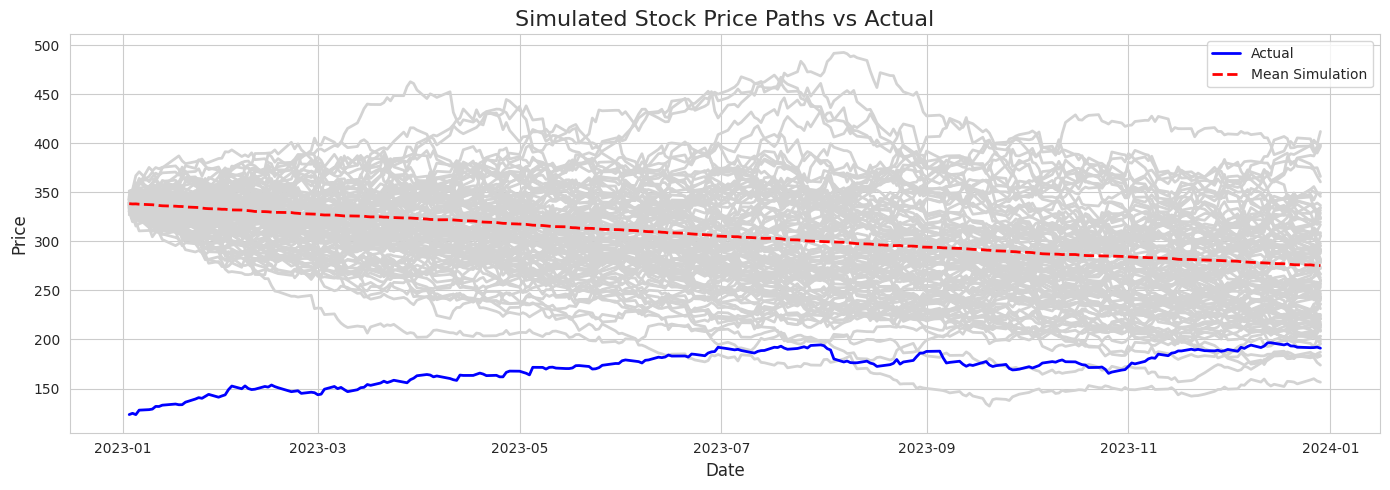

In [152]:
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

for i in range(min(100, len(paths))):
    plt.plot(dates, paths[i], color='lightgrey', alpha = 1, linewidth = 2)

plt.plot(dates, actual, label='Actual', color='blue', linewidth=2)
plt.plot(dates, np.mean(paths, axis=0), label='Mean Simulation', color='red', linestyle='--', linewidth=2)

plt.title("Simulated Stock Price Paths vs Actual", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
